# GMM

## EM algorythm

$$
\pi_{k}^{\mathrm{new}}=\frac{N_{k}}{N}\\
\boldsymbol{\mu}_{k}^{\text { new }}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma_{n k} \boldsymbol{x}_{n}\\
\boldsymbol\Lambda_{k}^{-1 \mathrm{new}}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma_{n k} \boldsymbol{x}_{n} \boldsymbol{x}_{n}^{T}-\boldsymbol{\mu}_{k}^{\mathrm{new}} \boldsymbol{\mu}_{k}^{\mathrm{new} \mathrm{T}}
$$
where,
$$
N_{k}=\sum_{n=1}^{N} \gamma_{n k}
$$
$$
\gamma_{n k}=\frac{\pi_{k} N\left(x_{n} | \boldsymbol{\mu}_{k}, \mathbf{\Lambda}_{k}^{-1}\right)}{\sum_{k^{\prime}=1}^{K} \pi_{k^{\prime}} N\left(\boldsymbol{x}_{n} | \boldsymbol{\mu}_{k^{\prime}}, \boldsymbol{\Lambda}_{k^{\prime}}^{-1}\right)}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import multivariate_normal as multi_gauss
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class EM_GMM:
    def __init__(self,K):
        self.K=K
        
    def E_step(self,X,pi,mu,Sigma):
        gamma=np.zeros((self.N,self.K))
        
        for n in range(self.N):
            for k in range(self.K):
                gamma[n,k]= pi[k]*self.gauss(X[n].reshape(self.D, 1), mu[k].reshape(self.D, 1), Sigma[k])
          

        gamma=gamma/np.sum(gamma, axis=1, keepdims=True)        
    
        return gamma
        
    def M_step(self,X,gamma):
        Nk=np.sum(gamma,axis=0)
        pi=Nk/self.N
        mu=np.zeros((self.K,self.D))
        Sigma=np.zeros((self.K,self.D,self.D))
        temp=np.zeros((self.N,self.D,self.D))
        for n in range(self.N):
            temp[n]=np.dot(X[n].reshape(self.D,1),X[n].reshape(1,self.D))
        for k in range(self.K):
            mu[k]=np.average(X,axis=0,weights=gamma[:,k])
            Sigma[k]=np.average(temp,axis=0,weights=gamma[:,k])-np.dot(mu[k].reshape(self.D,1),mu[k].reshape(1,self.D))
        
        return pi,mu,Sigma
    
    def gauss(self, x, mu, Sigma):
            x=x.reshape(self.D,1)
            mu=mu.reshape(self.D,1)
            return   np.exp(-0.5*(x-mu).T @ np.linalg.inv(Sigma)@(x-mu))/(np.linalg.det(Sigma) * np.sqrt(2 *np.pi)**self.D)
        
    def loglikelihood(self, X,pi,mu,Sigma):
    # compute log likelohood
        logL = 0
        for n in range(self.N):
            L = 0
            for k in range(self.K):
                L += pi[k] * self.gauss(X[n].reshape(self.D, 1), mu[k].reshape(self.D, 1), Sigma[k])
            logL += np.log(L)
        return logL

    def classify(self, X,pi,mu,Sigma):
        gamma = np.zeros((self.N,self.K))
        for n in range(self.N):     
            for k in range(self.K):
                gamma[n, k] = pi[k] * self.gauss(X[n].reshape(self.D, 1), self.mu[k].reshape(self.D, 1), self.Sigma[k])
        gamma=gamma/np.sum(gamma, axis=1, keepdims=True)

        return gamma, np.argmax(gamma, axis=1)
        
    def fit(self,X,T=100):
        #initialize
        self.D = len(X[0])
        self.N=X.shape[0]
        pi=np.ones(self.K)/self.K
        mu0 = np.mean(X,axis=0)
        mu=np.random.uniform(X.min(), X.max(), (self.K, self.D))
        Sigma=np.zeros((self.K,self.D,self.D))
        temp=np.dot(X.T,X)/self.N
        for k in range(self.K):
            Sigma[k]=temp
        
        #EM algorythm
        record=[]
        for step in range(T):
            gamma = self.E_step(X,pi,mu,Sigma)
            pi,mu,Sigma=self.M_step(X,gamma)
            
            logL = self.loglikelihood(X,pi,mu,Sigma)
            print("iter: %d, log likelihood: %f" % (step, logL))
            record.append([step, logL])
            if step == 0:
                oldL = logL
            else:
                if logL - oldL < 1e-5:
                    print("breaked")
                    break
                else:
                    oldL = logL

        self.pi=pi
        self.mu=mu
        self.Sigma=Sigma
        
        return np.array(record)

In [3]:
X = np.loadtxt("x.csv", delimiter=",")
gmm = EM_GMM(4)
record = gmm.fit(X, 100)
gamma, labels = gmm.classify(X,gmm.pi,gmm.mu,gmm.Sigma)

iter: 0, log likelihood: -89842.850601
iter: 1, log likelihood: -89100.863614
iter: 2, log likelihood: -84373.313521
iter: 3, log likelihood: -75787.685201
iter: 4, log likelihood: -70841.695423
iter: 5, log likelihood: -69020.953043
iter: 6, log likelihood: -67539.371575
iter: 7, log likelihood: -64994.921849
iter: 8, log likelihood: -61990.960767
iter: 9, log likelihood: -60560.098923
iter: 10, log likelihood: -59971.336261
iter: 11, log likelihood: -59434.089810
iter: 12, log likelihood: -58671.070596
iter: 13, log likelihood: -58000.545772
iter: 14, log likelihood: -57878.212356
iter: 15, log likelihood: -57875.581612
iter: 16, log likelihood: -57875.561716
iter: 17, log likelihood: -57875.561128
iter: 18, log likelihood: -57875.561105
iter: 19, log likelihood: -57875.561105
breaked


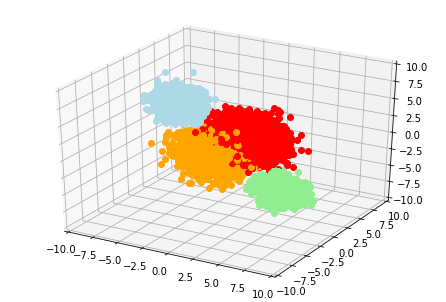

In [4]:
# save data
np.savetxt("z.csv", gamma, delimiter=",")
with open("params.dat", "w") as f:
    f.write("pi:\n")
    for k in range(gmm.K):
        f.write("cluster %d: %f\n" % (k, gmm.pi[k]))
    f.write("\nmeans:\n")
    for k in range(gmm.K):
        f.write("cluster %d: %s\n" % (k, gmm.mu[k]))
    f.write("\nprecison matrix:\n")
    for k in range(gmm.K):
        f.write("cluster %d\n" % k)
        f.write("%s\n" % np.linalg.inv(gmm.Sigma[k]))
with open("em_likelihood.txt", "w") as f:
    f.write("step\tlog-likelihood\n")
    for i in range(len(record)):
        f.write("%d\t%f\n" % (record[i, 0], record[i, 1]))
# plot
colors = ["red", "lightblue", "lightgreen", "orange"]
label_color = [colors[int(label)] for label in labels]
fig = plt.figure()
ax = Axes3D(fig)
for i in range(X.shape[0]):
    ax.plot([X[i, 0]], [X[i, 1]], [X[i, 2]], "o", color=label_color[i])
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
plt.savefig("em.png")
plt.show()
plt.close()